In [1]:
#import pandas and sqlite
import pandas as pd
import sqlite3 as sl

In [2]:
#connecct to database object
conn = sl.connect('NYT_covid.db')
c = conn.cursor()

In [3]:
#confirm tables present
res = conn.execute("SELECT name FROM sqlite_master WHERE type='table';")
for name in res:
    print (name[0])

deaths
mask_use
us
election
counties
states
regions


In [4]:
#update counties table with most recent data
counties = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv', index_col=0, encoding='latin-1')

c.execute('DROP TABLE IF EXISTS counties')
c.execute('CREATE TABLE counties (date datetime, county str, state str, fips str, cases int, deaths int, confirmed_cases int, confirmed_deaths int, probable_cases int, probable_deaths int)')
conn.commit()

counties.to_sql('counties',conn, if_exists='replace')

In [5]:
df = pd.read_sql('''SELECT * FROM counties WHERE state = 'Illinois' AND county = 'Cook' ORDER by date asc''',conn)
df

,date,county,state,fips,cases,deaths
0,2020-01-24,Cook,Illinois,17031.0,1,0.0
1,2020-01-25,Cook,Illinois,17031.0,1,0.0
2,2020-01-26,Cook,Illinois,17031.0,1,0.0
3,2020-01-27,Cook,Illinois,17031.0,1,0.0
4,2020-01-28,Cook,Illinois,17031.0,1,0.0
...,...,...,...,...,...,...
324,2020-12-13,Cook,Illinois,17031.0,352409,7340.0
325,2020-12-14,Cook,Illinois,17031.0,355467,7440.0
326,2020-12-15,Cook,Illinois,17031.0,358014,7458.0
327,2020-12-16,Cook,Illinois,17031.0,360117,7505.0


In [6]:
df = pd.read_sql('''SELECT date, county, state, cases as 'Total_cases_to_date'
                    FROM counties 
                    WHERE state = 'Illinois'
                    AND county = 'Cook'
                    ''',conn)
df

,date,county,state,Total_cases_to_date
0,2020-01-24,Cook,Illinois,1
1,2020-01-25,Cook,Illinois,1
2,2020-01-26,Cook,Illinois,1
3,2020-01-27,Cook,Illinois,1
4,2020-01-28,Cook,Illinois,1
...,...,...,...,...
324,2020-12-13,Cook,Illinois,352409
325,2020-12-14,Cook,Illinois,355467
326,2020-12-15,Cook,Illinois,358014
327,2020-12-16,Cook,Illinois,360117


In [7]:
#we are going to explore LAG.  LAG is a window funcgtion that allows you to use values from previous rows.  
#By default, the offset is 1 (meaning the previous row is used)

df = pd.read_sql('''SELECT date, state, county, 
                    cases - LAG (cases,1) OVER (ORDER BY date) as 'new_cases',
                    cases as 'cumulative_cases',
                    deaths - LAG (deaths,1) OVER (ORDER BY date) as 'new_deaths',
                    deaths as 'cumulative_deaths'
                    FROM counties
                    WHERE state = 'Illinois'
                    AND county = 'Cook'
                    ''',conn)
df

,date,state,county,new_cases,cumulative_cases,new_deaths,cumulative_deaths
0,2020-01-24,Illinois,Cook,NaN,1,NaN,0.0
1,2020-01-25,Illinois,Cook,0.0,1,0.0,0.0
2,2020-01-26,Illinois,Cook,0.0,1,0.0,0.0
3,2020-01-27,Illinois,Cook,0.0,1,0.0,0.0
4,2020-01-28,Illinois,Cook,0.0,1,0.0,0.0
...,...,...,...,...,...,...,...
324,2020-12-13,Illinois,Cook,2948.0,352409,21.0,7340.0
325,2020-12-14,Illinois,Cook,3058.0,355467,100.0,7440.0
326,2020-12-15,Illinois,Cook,2547.0,358014,18.0,7458.0
327,2020-12-16,Illinois,Cook,2103.0,360117,47.0,7505.0


In [8]:
# COMBINING WITH PARTITION BY ALLOWS US TO GROUP ALL THE COUNTIES TOGETHER

df = pd.read_sql('''SELECT date, state, county, 
                    cases - LAG (cases,1) OVER (PARTITION BY county ORDER BY date) as 'new_cases',
                    cases as 'cumulative_cases',
                    deaths - LAG (deaths,1) OVER (PARTITION BY county ORDER BY date) as 'new_deaths',
                    deaths as 'cumulative_deaths'
                    FROM counties
                    WHERE state = 'Illinois'
                    ''',conn)
df

,date,state,county,new_cases,cumulative_cases,new_deaths,cumulative_deaths
0,2020-03-20,Illinois,Adams,NaN,1,NaN,0.0
1,2020-03-21,Illinois,Adams,0.0,1,0.0,0.0
2,2020-03-22,Illinois,Adams,0.0,1,0.0,0.0
3,2020-03-23,Illinois,Adams,0.0,1,0.0,0.0
4,2020-03-24,Illinois,Adams,0.0,1,0.0,0.0
...,...,...,...,...,...,...,...
26803,2020-12-13,Illinois,Woodford,40.0,2308,0.0,36.0
26804,2020-12-14,Illinois,Woodford,39.0,2347,0.0,36.0
26805,2020-12-15,Illinois,Woodford,19.0,2366,4.0,40.0
26806,2020-12-16,Illinois,Woodford,32.0,2398,0.0,40.0


In [9]:
#using different partitioning gives different results.  I am going to use fips to get this for all states/counties

df = pd.read_sql('''SELECT date, state, county, 
                    cases - LAG (cases,1) OVER (PARTITION BY fips ORDER BY date) as 'new_cases',
                    cases as 'cumulative_cases',
                    deaths - LAG (deaths,1) OVER (PARTITION BY fips ORDER BY date) as 'new_deaths',
                    deaths as 'cumulative_deaths'
                    FROM counties
                    ORDER BY state, county''',conn)
df

,date,state,county,new_cases,cumulative_cases,new_deaths,cumulative_deaths
0,2020-03-24,Alabama,Autauga,NaN,1,NaN,0.0
1,2020-03-25,Alabama,Autauga,3.0,4,0.0,0.0
2,2020-03-26,Alabama,Autauga,2.0,6,0.0,0.0
3,2020-03-27,Alabama,Autauga,0.0,6,0.0,0.0
4,2020-03-28,Alabama,Autauga,0.0,6,0.0,0.0
...,...,...,...,...,...,...,...
839381,2020-12-13,Wyoming,Weston,0.0,428,0.0,2.0
839382,2020-12-14,Wyoming,Weston,1.0,429,0.0,2.0
839383,2020-12-15,Wyoming,Weston,7.0,436,0.0,2.0
839384,2020-12-16,Wyoming,Weston,0.0,436,0.0,2.0


In [10]:
df = pd.read_sql('''SELECT date, state, county, 
                    cases - LAG (cases,1) OVER (PARTITION BY fips ORDER BY date) as 'new_cases',
                    cases as 'cumulative_cases',
                    deaths - LAG (deaths,1) OVER (PARTITION BY fips ORDER BY date) as 'new_deaths',
                    deaths as 'cumulative_deaths'
                    FROM counties
                    ORDER BY state, county''',conn)

df

,date,state,county,new_cases,cumulative_cases,new_deaths,cumulative_deaths
0,2020-03-24,Alabama,Autauga,NaN,1,NaN,0.0
1,2020-03-25,Alabama,Autauga,3.0,4,0.0,0.0
2,2020-03-26,Alabama,Autauga,2.0,6,0.0,0.0
3,2020-03-27,Alabama,Autauga,0.0,6,0.0,0.0
4,2020-03-28,Alabama,Autauga,0.0,6,0.0,0.0
...,...,...,...,...,...,...,...
839381,2020-12-13,Wyoming,Weston,0.0,428,0.0,2.0
839382,2020-12-14,Wyoming,Weston,1.0,429,0.0,2.0
839383,2020-12-15,Wyoming,Weston,7.0,436,0.0,2.0
839384,2020-12-16,Wyoming,Weston,0.0,436,0.0,2.0


In [11]:
#Now we will add in some rolling averages for new cases and new deaths, we have to use a cte to do this 

df = pd.read_sql('''WITH cte as (SELECT date, state, county, 
                    cases - LAG (cases,1) OVER (PARTITION BY fips ORDER BY date) as 'new_cases',
                    cases as 'cumulative_cases',
                    deaths - LAG (deaths,1) OVER (PARTITION BY fips ORDER BY date) as 'new_deaths',
                    deaths as 'cumulative_deaths'
                    FROM counties
                    ORDER BY state, county)
                    
                    SELECT date, state, county, new_cases, cumulative_cases,
                    AVG(new_cases) OVER (PARTITION BY state, county ORDER BY date ASC rows 6 PRECEDING) as '7-day_avg_new',
                    new_deaths, cumulative_deaths,
                    AVG(new_deaths) OVER (PARTITION BY state, county ORDER BY date ASC rows 6 PRECEDING) as '7-day_avg_death'
                    FROM cte
                    ORDER BY state, county, date
                    ''',conn)
df

,date,state,county,new_cases,cumulative_cases,7-day_avg_new,new_deaths,cumulative_deaths,7-day_avg_death
0,2020-03-24,Alabama,Autauga,NaN,1,NaN,NaN,0.0,NaN
1,2020-03-25,Alabama,Autauga,3.0,4,3.000000,0.0,0.0,0.0
2,2020-03-26,Alabama,Autauga,2.0,6,2.500000,0.0,0.0,0.0
3,2020-03-27,Alabama,Autauga,0.0,6,1.666667,0.0,0.0,0.0
4,2020-03-28,Alabama,Autauga,0.0,6,1.250000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
839381,2020-12-13,Wyoming,Weston,0.0,428,1.142857,0.0,2.0,0.0
839382,2020-12-14,Wyoming,Weston,1.0,429,1.000000,0.0,2.0,0.0
839383,2020-12-15,Wyoming,Weston,7.0,436,1.571429,0.0,2.0,0.0
839384,2020-12-16,Wyoming,Weston,0.0,436,1.285714,0.0,2.0,0.0


In [12]:
cook = pd.read_sql('''WITH cte as (SELECT date, state, county, 
                    cases - LAG (cases,1) OVER (PARTITION BY fips ORDER BY date) as 'new_cases',
                    cases as 'cumulative_cases',
                    deaths - LAG (deaths,1) OVER (PARTITION BY fips ORDER BY date) as 'new_deaths',
                    deaths as 'cumulative_deaths'
                    FROM counties
                    ORDER BY state, county)
                    
                    SELECT date, state, county, new_cases, cumulative_cases,
                    AVG(new_cases) OVER (PARTITION BY state, county ORDER BY date ASC rows 6 PRECEDING) as '7-day_avg_new',
                    new_deaths, cumulative_deaths,
                    AVG(new_deaths) OVER (PARTITION BY state, county ORDER BY date ASC rows 6 PRECEDING) as '7-day_avg_death'
                    FROM cte
                    WHERE state = 'Illinois' and county = 'Cook'
                    ORDER BY date''',conn)
cook

,date,state,county,new_cases,cumulative_cases,7-day_avg_new,new_deaths,cumulative_deaths,7-day_avg_death
0,2020-01-24,Illinois,Cook,NaN,1,NaN,NaN,0.0,NaN
1,2020-01-25,Illinois,Cook,0.0,1,0.000000,0.0,0.0,0.000000
2,2020-01-26,Illinois,Cook,0.0,1,0.000000,0.0,0.0,0.000000
3,2020-01-27,Illinois,Cook,0.0,1,0.000000,0.0,0.0,0.000000
4,2020-01-28,Illinois,Cook,0.0,1,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...
324,2020-12-13,Illinois,Cook,2948.0,352409,3343.714286,21.0,7340.0,55.571429
325,2020-12-14,Illinois,Cook,3058.0,355467,3253.428571,100.0,7440.0,60.285714
326,2020-12-15,Illinois,Cook,2547.0,358014,3258.571429,18.0,7458.0,58.142857
327,2020-12-16,Illinois,Cook,2103.0,360117,3146.285714,47.0,7505.0,53.000000


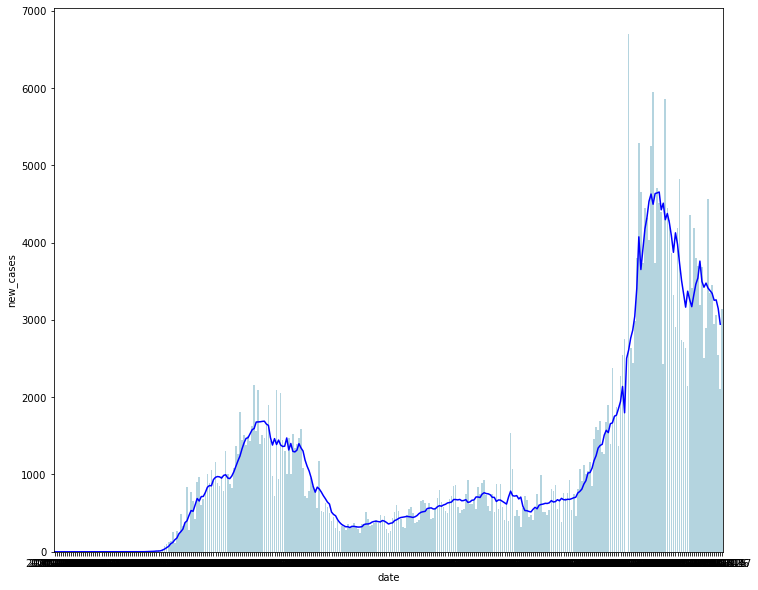

In [13]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
x = cook['date']
y = cook['7-day_avg_new']
y2 = cook['new_cases']

fig, ax = plt.subplots(figsize=(12,10))
sns.lineplot(x,y, color = 'blue')
sns.barplot(x,y2, color = 'lightblue');


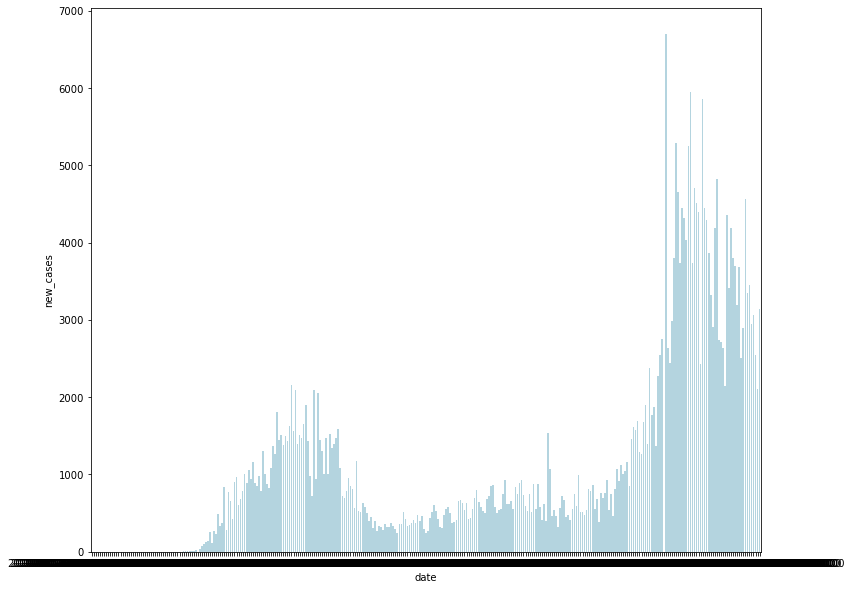

In [14]:
import datetime as dt
import matplotlib.dates as mdates

left = dt.date(2020,1,24)
right = dt.date(2020,10,31)
x = pd.to_datetime(cook['date'])
y = cook['7-day_avg_new']
y2 = cook['new_cases']

fig, ax = plt.subplots(figsize=(12,10))
ax1=sns.lineplot(x,y, color = 'blue')
ax2=sns.barplot(x,y2, color = 'lightblue');

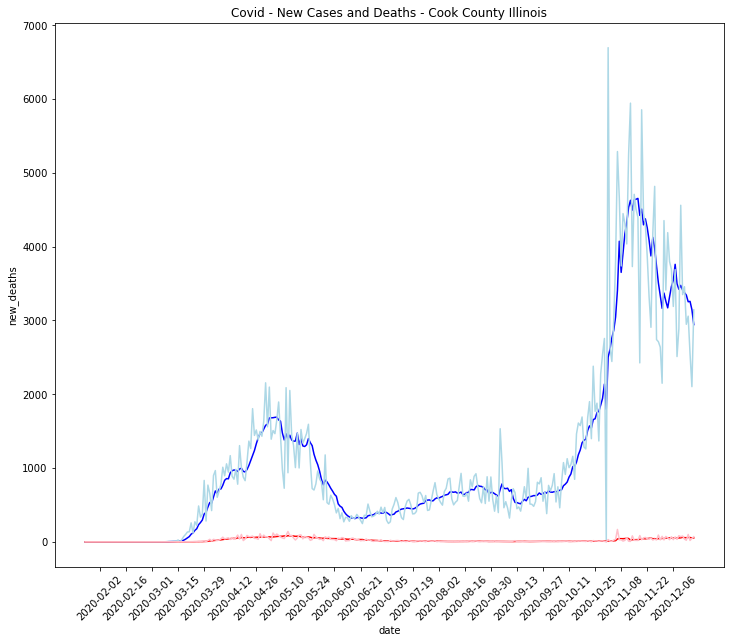

In [15]:
import numpy as np

x = cook['date']
y = cook['7-day_avg_new']
y2 = cook['new_cases']
y3 = cook['7-day_avg_death']
y4 = cook['new_deaths']

fig, ax = plt.subplots(figsize=(12,10))
sns.lineplot(x,y, color = 'blue')
sns.lineplot(x,y2, color = 'lightblue')
sns.lineplot(x,y3, color = 'red')
sns.lineplot(x,y4, color = 'pink');
plt.xticks((np.arange(8, 330, step=14)),rotation=45)
plt.title('Covid - New Cases and Deaths - Cook County Illinois');



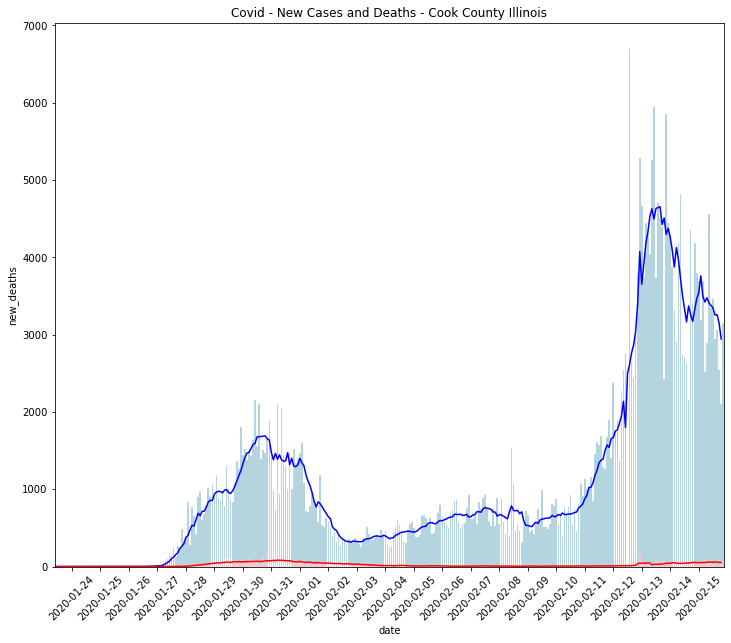

In [16]:
x = cook['date']
y = cook['7-day_avg_new']
y2 = cook['new_cases']
y3 = cook['7-day_avg_death']
y4 = cook['new_deaths']

fig, ax = plt.subplots(figsize=(12,10))
sns.lineplot(x,y, color = 'blue')
sns.barplot(x,y2, color = 'lightblue')
sns.lineplot(x,y3, color = 'red')
sns.barplot(x,y4, color = 'pink');
plt.xticks((np.arange(8, 330, step=14)),rotation=45)
plt.title('Covid - New Cases and Deaths - Cook County Illinois');

In [17]:
illinois = pd.read_sql('''WITH cte as (SELECT date, state, 
                    cases - LAG (cases,1) OVER (PARTITION BY state ORDER BY date) as 'new_cases',
                    cases as 'cumulative_cases',
                    deaths - LAG (deaths,1) OVER (PARTITION BY state ORDER BY date) as 'new_deaths',
                    deaths as 'cumulative_deaths'
                    FROM counties
                    ORDER BY state)
                    
                    SELECT date, state, new_cases, cumulative_cases,
                    AVG(new_cases) OVER (PARTITION BY state ORDER BY date ASC rows 6 PRECEDING) as '7-day_avg_new',
                    new_deaths, cumulative_deaths,
                    AVG(new_deaths) OVER (PARTITION BY state ORDER BY date ASC rows 6 PRECEDING) as '7-day_avg_death'
                    FROM cte
                    WHERE state = 'Illinois'
                    ORDER BY date''',conn)
illinois

,date,state,new_cases,cumulative_cases,7-day_avg_new,new_deaths,cumulative_deaths,7-day_avg_death
0,2020-01-24,Illinois,NaN,1,NaN,NaN,0.0,NaN
1,2020-01-25,Illinois,0.0,1,0.000000,0.0,0.0,0.000000
2,2020-01-26,Illinois,0.0,1,0.000000,0.0,0.0,0.000000
3,2020-01-27,Illinois,0.0,1,0.000000,0.0,0.0,0.000000
4,2020-01-28,Illinois,0.0,1,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...
26803,2020-12-17,Illinois,3548.0,4481,429.142857,134.0,151.0,17.428571
26804,2020-12-17,Illinois,43418.0,47899,6097.142857,547.0,698.0,88.428571
26805,2020-12-17,Illinois,-43272.0,4627,530.428571,-594.0,104.0,13.428571
26806,2020-12-17,Illinois,17861.0,22488,3017.857143,229.0,333.0,43.571429


In [18]:
df = pd.read_sql('''SELECT * FROM states WHERE state = 'Illinois' ORDER BY date desc LIMIT 50;''',conn)
df

,date,state,fips,cases,deaths
0,2020-12-17,Illinois,17,881229,15987
1,2020-12-16,Illinois,17,872294,15780
2,2020-12-15,Illinois,17,865261,15591
3,2020-12-14,Illinois,17,857860,15458
4,2020-12-13,Illinois,17,850412,15340
5,2020-12-12,Illinois,17,843328,15232
6,2020-12-11,Illinois,17,834668,15076
7,2020-12-10,Illinois,17,825136,14852
8,2020-12-09,Illinois,17,813990,14621
9,2020-12-08,Illinois,17,805794,14392


In [19]:
illinois = pd.read_sql('''WITH cte as (SELECT date, state, 
                    cases - LAG (cases,1) OVER (PARTITION BY state ORDER BY date) as 'new_cases',
                    cases as 'cumulative_cases',
                    deaths - LAG (deaths,1) OVER (PARTITION BY state ORDER BY date) as 'new_deaths',
                    deaths as 'cumulative_deaths'
                    FROM states
                    ORDER BY state)
                    
                    SELECT date, state, new_cases, cumulative_cases,
                    AVG(new_cases) OVER (PARTITION BY state ORDER BY date ASC rows 6 PRECEDING) as '7-day_avg_new',
                    new_deaths, cumulative_deaths,
                    AVG(new_deaths) OVER (PARTITION BY state ORDER BY date ASC rows 6 PRECEDING) as '7-day_avg_death'
                    FROM cte
                    WHERE state = 'Illinois'
                    ORDER BY date''',conn)
illinois

,date,state,new_cases,cumulative_cases,7-day_avg_new,new_deaths,cumulative_deaths,7-day_avg_death
0,2020-01-24,Illinois,NaN,1,NaN,NaN,0,NaN
1,2020-01-25,Illinois,0.0,1,0.000000,0.0,0,0.000000
2,2020-01-26,Illinois,0.0,1,0.000000,0.0,0,0.000000
3,2020-01-27,Illinois,0.0,1,0.000000,0.0,0,0.000000
4,2020-01-28,Illinois,0.0,1,0.000000,0.0,0,0.000000
...,...,...,...,...,...,...,...,...
324,2020-12-13,Illinois,7084.0,850412,8784.285714,108.0,15340,173.285714
325,2020-12-14,Illinois,7448.0,857860,8581.571429,118.0,15458,174.857143
326,2020-12-15,Illinois,7401.0,865261,8495.285714,133.0,15591,171.285714
327,2020-12-16,Illinois,7033.0,872294,8329.142857,189.0,15780,165.571429


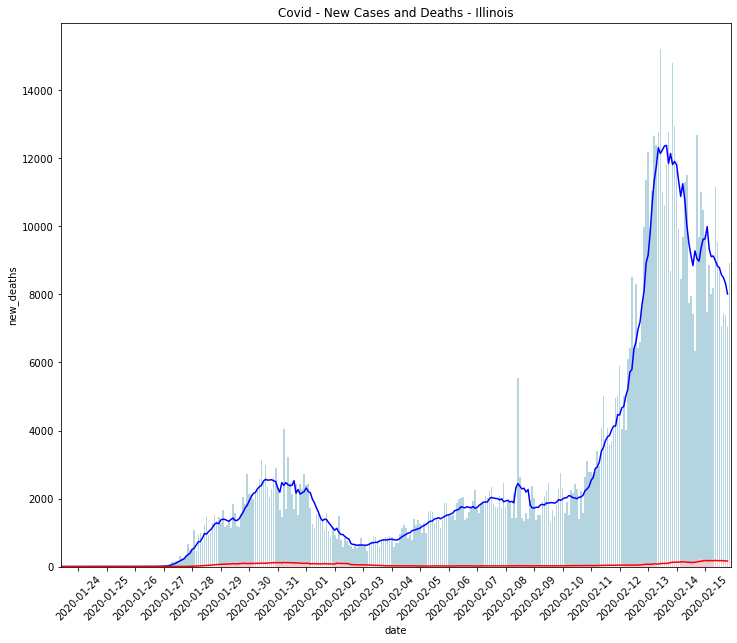

In [20]:
x = illinois['date']
y = illinois['7-day_avg_new']
y2 = illinois['new_cases']
y3 = illinois['7-day_avg_death']
y4 = illinois['new_deaths']

fig, ax = plt.subplots(figsize=(12,10))
sns.lineplot(x,y, color = 'blue')
sns.barplot(x,y2, color = 'lightblue')
sns.lineplot(x,y3, color = 'red')
sns.barplot(x,y4, color = 'pink');
plt.xticks((np.arange(8, 330, step=14)),rotation=45)
plt.title('Covid - New Cases and Deaths - Illinois');

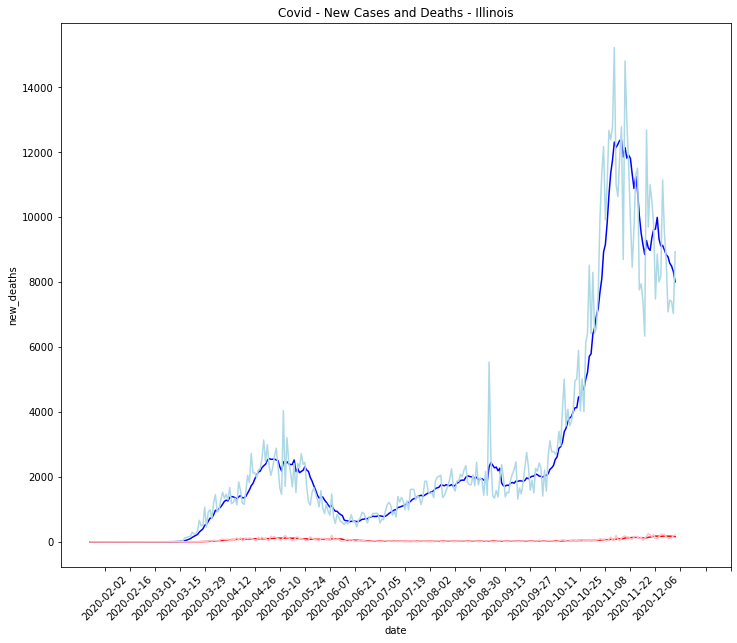

In [24]:
x = illinois['date']
y = illinois['7-day_avg_new']
y2 = illinois['new_cases']
y3 = illinois['7-day_avg_death']
y4 = illinois['new_deaths']

fig, ax = plt.subplots(figsize=(12,10))
sns.lineplot(x,y, color = 'blue')
sns.lineplot(x,y2, color = 'lightblue')
sns.lineplot(x,y3, color = 'red')
sns.lineplot(x,y4, color = 'pink');
plt.xticks((np.arange(8, 365, step=14)),rotation=45)
plt.title('Covid - New Cases and Deaths - Illinois');

In [22]:
il_pop = 12700000

illinois = pd.read_sql('''WITH cte as (SELECT date, state, 
                    cases - LAG (cases,1) OVER (PARTITION BY state ORDER BY date) as 'new_cases',
                    cases as 'cumulative_cases',
                    deaths - LAG (deaths,1) OVER (PARTITION BY state ORDER BY date) as 'new_deaths',
                    deaths as 'cumulative_deaths'
                    FROM states
                    ORDER BY state)
                    
                    SELECT date, state, new_cases, cumulative_cases, ROUND(cumulative_cases/12700,1) as 'cases_per_million',
                    AVG(new_cases) OVER (PARTITION BY state ORDER BY date ASC rows 6 PRECEDING) as '7-day_avg_new',
                    new_deaths, cumulative_deaths,
                    AVG(new_deaths) OVER (PARTITION BY state ORDER BY date ASC rows 6 PRECEDING) as '7-day_avg_death'
                    FROM cte
                    WHERE state = 'Illinois'
                    ORDER BY date''',conn)
illinois

,date,state,new_cases,cumulative_cases,cases_per_million,7-day_avg_new,new_deaths,cumulative_deaths,7-day_avg_death
0,2020-01-24,Illinois,NaN,1,0.0,NaN,NaN,0,NaN
1,2020-01-25,Illinois,0.0,1,0.0,0.000000,0.0,0,0.000000
2,2020-01-26,Illinois,0.0,1,0.0,0.000000,0.0,0,0.000000
3,2020-01-27,Illinois,0.0,1,0.0,0.000000,0.0,0,0.000000
4,2020-01-28,Illinois,0.0,1,0.0,0.000000,0.0,0,0.000000
...,...,...,...,...,...,...,...,...,...
324,2020-12-13,Illinois,7084.0,850412,66.0,8784.285714,108.0,15340,173.285714
325,2020-12-14,Illinois,7448.0,857860,67.0,8581.571429,118.0,15458,174.857143
326,2020-12-15,Illinois,7401.0,865261,68.0,8495.285714,133.0,15591,171.285714
327,2020-12-16,Illinois,7033.0,872294,68.0,8329.142857,189.0,15780,165.571429


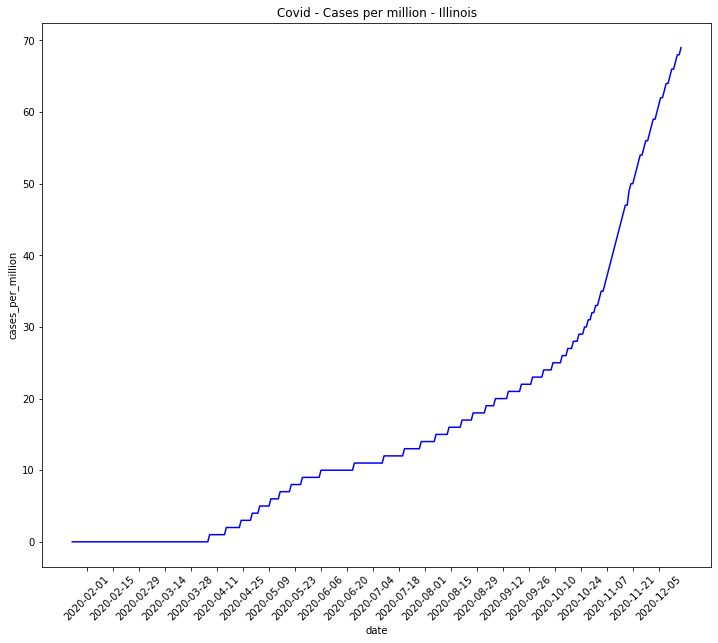

In [23]:
x = illinois['date']
y = illinois['cases_per_million']
# y2 = illinois['new_cases']
# y3 = illinois['7-day_avg_death']
# y4 = illinois['new_deaths']

fig, ax = plt.subplots(figsize=(12,10))
sns.lineplot(x,y, color = 'blue')
# sns.lineplot(x,y2, color = 'lightblue')
# sns.lineplot(x,y3, color = 'red')
# sns.lineplot(x,y4, color = 'pink');
plt.xticks((np.arange(8, 330, step=14)),rotation=45)
plt.title('Covid - Cases per million - Illinois');